In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: xlabel='x', ylabel='y'>

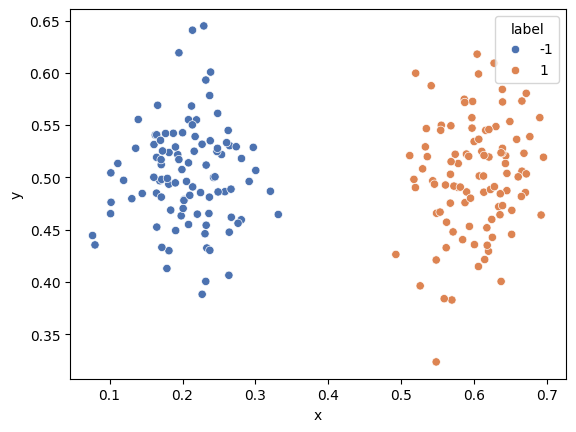

In [ ]:
GROUP_SIZE = 100
def generate_array(m1, d1, m2, d2,  size=GROUP_SIZE):
  return np.concatenate(
    (
      np.random.normal(m1, d1, size=size),
      np.random.normal(m2, d2, size=size)
    )
  )


df = pd.DataFrame(
  {
    'x': generate_array(0.2, 0.05, 0.6, 0.05),
    'y': generate_array(0.5, 0.05, 0.5, 0.05),
    'label': np.array([-1] * GROUP_SIZE + [1] * GROUP_SIZE)
  }
)

X = df[['x', 'y']]
y = df[['label']]

sns.scatterplot(data=df, x='x', y='y', hue='label', palette="deep")

In [ ]:
class Linear_classifier_base:

    def __init__(self, X : pd.DataFrame, y : pd.DataFrame) -> None:
        self.X = X
        self.y = y

        self.X["bias"] = np.ones(len(X))
        self.size = len(self.X)
        self.k = len(self.X.iloc[0])
        self.weights = None
        self.weights_history = []


    def loss(self, loss_function) -> float:
        loss = 0
        for i in range(self.size):
            x, y = np.dot(self.X.values[i], self.weights), self.y.values[i][0]
            loss += loss_function(x, y)

        return loss


    def stochastic_gradient_descent(self, loss_function, update_rule,
                                    lambda_param : float = 0.01, learning_rate : float = 0.001,
                                    eps : float = 1e-5) -> None:
        self.weights = np.random.uniform(-1 / (2 * self.k), 1 / (2 * self.k), self.k)
        current_loss = self.loss(loss_function)
        self.weights_history.append(self.weights)
        for step in range(1, 30000):
            errors = [i for i in range(self.size) if np.dot(self.X.values[i], self.weights) * self.y.values[i][0] < 0]

            if len(errors) == 0:
              break

            idx = errors[np.random.randint(len(errors))] if len(errors) else np.random.randint(self.size)
            x = self.X.values[idx]
            y = self.y.values[idx]
            f = np.dot(x, self.weights) * y

            self.weights = update_rule(self.weights, f, x, y, learning_rate)
            self.weights_history.append(self.weights)

            loss = (1 - lambda_param) * current_loss + lambda_param * loss_function(f, y)

            if abs(loss - current_loss) < eps:
                return

            current_loss = loss


    def predict(self, point : np.ndarray) -> tuple[int, float]:
        point = np.append(point, 1)
        f = np.sum(point * self.weights)

        return np.sign(f), f


    def visualize(self) -> None:
        plt.axis([0, 1, 0, 1])
        x = np.linspace(-2, 2, 100)

        for [A, B, C] in self.weights_history:
            plt.plot(x, (-C - A * x) / B, color="blue", linewidth=0.5)

        plt.plot(x, (-self.weights[2] - self.weights[0] * x) / self.weights[1], color = "red")

        dot_color = {1 : "red", -1 : "green"}

        for idx in range(self.size):
            plt.scatter(self.X['x'].values[idx], self.X['y'].values[idx],
                  color=dot_color[self.y.values[idx][0]], zorder=10)

        plt.show()

Будем рассматривать задачу вида: \\
Пусть нам дано множество объектов $X^l$ и множество ответов $Y = \{-1, 1\}$. Тогда очевидно, что алгоритм бдует иметь вид:
$$a(x) = sign( <w, x> - \space w_0) $$
По сути эту задачу можно рассматривать как задачу регресии, иначе говоря мы полгаем восстановить зависимость в виде:
$$f(X) = wX - w_0$$
А затем приметь $sign$ к предсказаниям, чтобы получить метку класса. \\
Будем решать такую задачу следующим образом: \\
Зададим функцию потерь, которая будет показывать насколько сильно и часто мы ошибаемся:
$$\sum_{i} [y \ne sign(f(X))] → \min_w$$
Перепишем в виде:
$$\sum_{i} [y f(X) \lt 0] → \min_w$$
Получим величину отступа $M = y<w, x_i>$. Отсюда получим:
$$F(M) = [M < 0] = \begin{equation*}
 \begin{cases}
   1, M < 0,
   \\
   0, M \ge 0
 \end{cases}
\end{equation*}$$
Такая функция на самом деле так себе, потому что она кусочно постоянная, производная везде 0, нам нужны какие-то другие функции. О их выборе позже, а пока рассмотрим метод, которым мы бы минимизовали веса. \\
Речь о градиентном спуске. Градиент - вектор, производных функции, который направлен в сторону её наибольшего роста. Будем искать антиградиент функции потерь, а затем "двигать" веса в ту сторону. Сам алгоритм:


1.   Инициализируем $w$
2.   Наш функционал качества имеет вид: $Q(a) = \sum_{i = 1}^{l} L(<w, x_i> y) → min_w$
3. Выберем $x_i \in X^l$
4. Посчитаем значение $L(M)$
5. Обновим веса $w = w - ηL'(M)$
6. $Q(a) = (1 - λ)Q + λL(M)$
7. Будем повторять либо пока изменяются веса, либо когда лосс будет совсем маленьким(в работе мы перестаем обновляться, когда веса не изменяются, но это на самом деле не очень хорошо, хотя выбора у нас нет)




In [ ]:
class ADALINE(Linear_classifier_base):

    def stochastic_gradient_descent(self, lambda_param: float = 0.01, learning_rate: float = 0.001, eps: float = 0.00001) -> None:
        def loss_function(f : np.ndarray, y : np.ndarray) -> np.ndarray:
            return (f * y - 1) ** 2

        def update_rule(weights : np.ndarray, f : np.ndarray, y : np.ndarray,
                        x : np.ndarray, learning_rate : float) -> np.ndarray:
            return weights - learning_rate * (f - y) * x

        return super(ADALINE, self).stochastic_gradient_descent(loss_function, update_rule, lambda_param, learning_rate, eps)

Так как для градиентного спуска нам нужны производная, а у $F(M) = [M < 0]$ ее просто нет, очевидно потому что она кусочно-постоянная, мы прибегаем к использованию другого лосса:
$$F(M) = (M - 1)^2$$
$$L(M) = \sum_{i}( M - 1)^2$$
$$L'(M) = \sum_{i}2(y_i, <w, x_i>)x_i$$

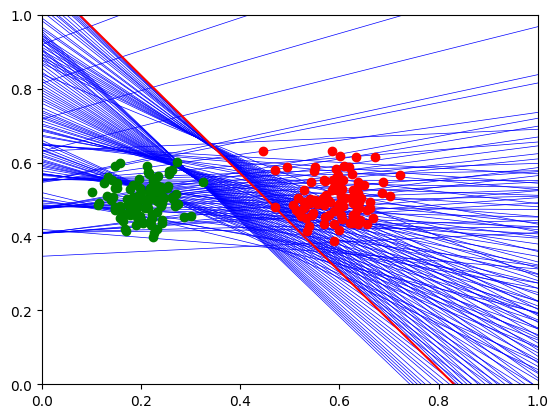

In [ ]:
adaline = ADALINE(X, y)
adaline.stochastic_gradient_descent(0.01, 0.01)
adaline.visualize()

In [ ]:
class Hebb_rule(Linear_classifier_base):
    def stochastic_gradient_descent(self, lambda_param: float = 0.01, learning_rate: float = 0.001, eps: float = 0.00001) -> None:
        def loss_function(f : np.ndarray, y : np.ndarray) -> np.ndarray:
            return max(0, -(f * y))

        def update_rule(weights : np.ndarray, f : np.ndarray, y : np.ndarray,
                        x : np.ndarray, learning_rate : float) -> np.ndarray:
            return weights + learning_rate * x * y

        return super(Hebb_rule, self).stochastic_gradient_descent(loss_function, update_rule, lambda_param, learning_rate, eps)

Возьмем:
$$F(M) = \max(0, -M)$$
Тогда:
$$L(M) = \sum_{i}\max(0, -y_i<w, x_i>)$$
$$L'(M) = \sum_{i}\begin{equation*}
 \begin{cases}
   0, M > 0,
   \\
   -y_ix_i, M \le 0
 \end{cases}
\end{equation*}
$$

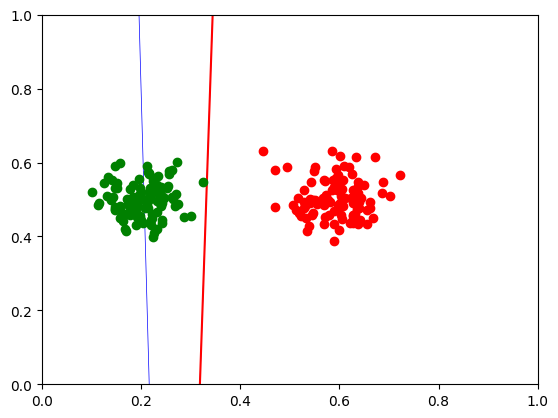

In [ ]:
hebb = Hebb_rule(X, y)
hebb.stochastic_gradient_descent(0.01, 0.01, 1e-2)
hebb.visualize()

Из-за того, что в формуле градиента модели ADALINE мы все таки взамодействуем со значением отступа $M$ - получается более точная разделяющая гиперплоскость, но из-за этого уменьшается сходимость. При этом перцептрон Розенблатта быстрее сходится, но ради этого мы жерствуем качеством модели и обобщающей способностью.

In [ ]:
class Logistic_regression(Linear_classifier_base):

    @staticmethod
    def sigmoid(x : np.ndarray) -> np.ndarray:
        return 1 / (1 + np.exp(x))


    def stochastic_gradient_descent(self, lambda_param: float = 0.01, learning_rate: float = 0.001, eps: float = 0.00001) -> None:
        def loss_function(f : np.ndarray, y : np.ndarray) -> np.ndarray:
            return np.log2(1 + np.exp(- f * y))

        def update_rule(weights : np.ndarray, f : np.ndarray, y : np.ndarray,
                        x : np.ndarray, learning_rate : float) -> np.ndarray:
            return weights + learning_rate * x * y * self.sigmoid(- f * y)

        return super(Logistic_regression, self).stochastic_gradient_descent(loss_function, update_rule, lambda_param, learning_rate, eps)


    def get_probas(self, points : np.ndarray) -> np.ndarray:
        sign = self.predict(points)[0]
        points = np.append(points, 1)
        return self.sigmoid(np.dot(self.weights, points) * sign)


    def predict_class(self, points : np.ndarray, threshold : float = 0.5) -> np.ndarray:
        probas = self.get_probas(points)
        classes = []
        for i in range(len(probas)):
            if probas[i] >= threshold:
                classes.append(1)
            else:
                classes.append(-1)

        return np.array(classes)

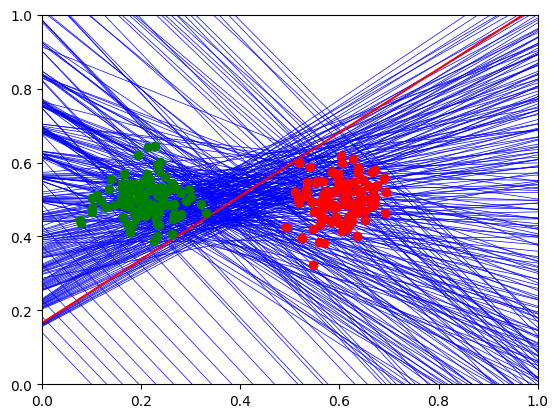

In [ ]:
LR = Logistic_regression(X, y)
LR.stochastic_gradient_descent(0.01, 0.01)
LR.visualize()

Вместо предсказания самого класса будем предсказывать вероятность положительного класса. Но вероятность лежит в промежутке $[0, 1]$, а для обычных моделей регрсессии мы в теории получаем значение $(-∞, ∞)$. Что же делать? Преобразуем ответ модели в вероятность:
$$<w, x_i> = \log{(\frac{p}{1 - p})}$$
Путем преобразований получим:
$$p = \frac{1}{1 + e^{-<w, x_i>}}$$
В правой части назовем функцию сигмоидой:
$$σ(z) = \frac{1}{1 + e^{-z}}$$
И, наконец, получим:
$$p = σ(<w, x_i>)$$
$$L(w, X, y) = \sum_{i}\log(1 + e^{-y_i, <w, x_i>)}$$
$$L'(w, X, y) = \sum_{i}x_i y_i σ(-<w, x_i> y_i)$$


In [ ]:
def draw_points_probas(model : object) -> None:
    step = 0.01
    min_value, max_value = 1, 0
    for i in np.arange(0, 1 + step, step):
        for j in np.arange(0, 1 + step, step):
            p = model.get_probas(np.array([i, j]))
            min_value, max_value = min(min_value, p), max(max_value, p)
    for i in np.arange(0, 1 + step, step):
        for j in np.arange(0, 1 + step, step):
            p = model.get_probas(np.array([i, j]))
            label = model.predict(np.array([i, j]))[0]
            percent = (p - min_value) / (max_value - min_value)
            color = (percent, 0, 0) if label == 1 else (0, 0, percent)
            plt.scatter(i, j, color=color)
    plt.show()

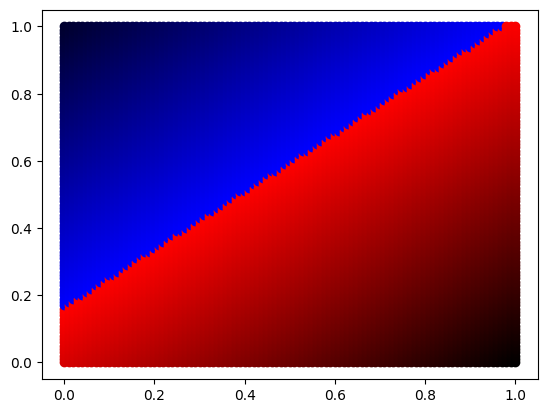

In [ ]:
draw_points_probas(LR)

У логистистической модели более гладкая функция потерь, качество классификации выше. К тому же если использовать ее по назначению(предсказывать классы 0 и 1), то открывается путь в очень интересные метрику - ROC AUС, которая позволяет оценить насколько хорошо наш классификатор разделяет классы.